<a href="https://colab.research.google.com/github/hlarsonhlarson/IBR_Test/blob/main/testIBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install scanpy
!pip3 install leidenalg

In [42]:
# Transposed given count matrix for easy parsing to anndata
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Учёба РНИМУ/counts.tab', sep='\t', engine='python', header=0, index_col=False)
transposed = data.set_index('gene').transpose()
transposed.to_csv('/content/drive/MyDrive/Учёба РНИМУ/counts_tranposed.tab', sep='\t')

In [43]:
import scanpy
import anndata

In [44]:
with open("/content/drive/MyDrive/Учёба РНИМУ/counts_tranposed.tab") as your_data:
    adata = anndata.read_csv(your_data, delimiter='\t', first_column_names=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [45]:
# basic filtering
adata.var_names_make_unique()
scanpy.pp.filter_cells(adata, min_genes=200)
scanpy.pp.filter_genes(adata, min_cells=3)


In [46]:
scanpy.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

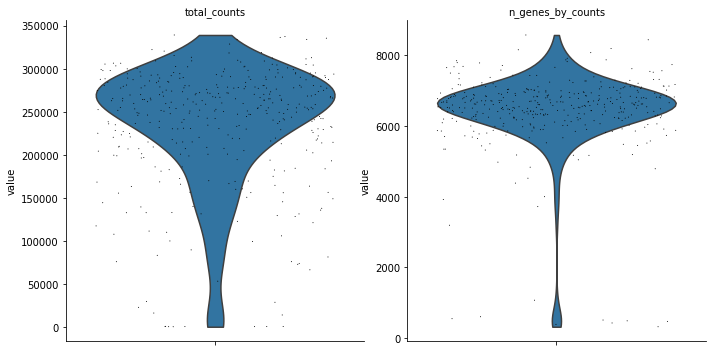

In [47]:
scanpy.pl.violin(adata, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

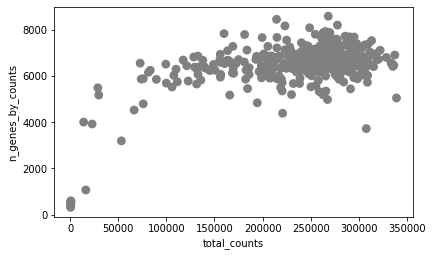

In [48]:
scanpy.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [49]:
# removed ejected points
adata = adata[adata.obs.n_genes_by_counts > 2500, :]

In [50]:
# normalize data
normalized_data = scanpy.pp.normalize_total(adata, target_sum=1e4, copy=True)

In [51]:
scanpy.pp.log1p(normalized_data)

In [52]:
scanpy.pp.highly_variable_genes(normalized_data, min_mean=0.0125, max_mean=3, min_disp=0.5)

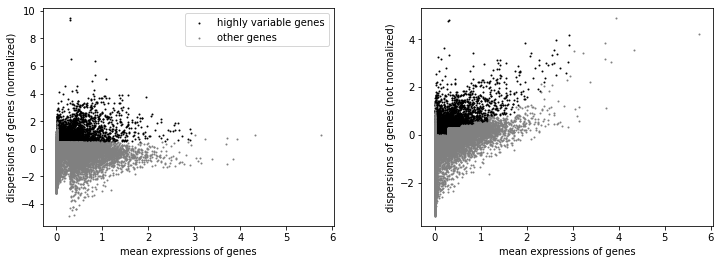

In [53]:
scanpy.pl.highly_variable_genes(normalized_data)

In [54]:
normalized_data.raw = normalized_data

In [55]:
#filtered highly variable genes
normalized_data = normalized_data[:,normalized_data.var.highly_variable]

In [56]:
# Regress out effects of total counts per cell
scanpy.pp.regress_out(normalized_data, ['total_counts'])

In [57]:
# cale each gene to unit variance
scanpy.pp.scale(normalized_data, max_value=10)

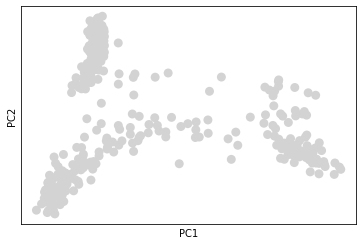

In [58]:
scanpy.pp.pca(normalized_data, svd_solver='arpack')
scanpy.pl.pca(normalized_data)

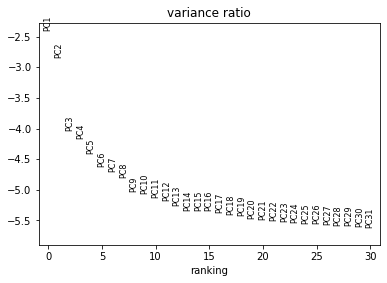

In [59]:
scanpy.pl.pca_variance_ratio(normalized_data, log=True)

In [60]:
normalized_data.write('/content/drive/MyDrive/Учёба РНИМУ/annDataFile')

In [61]:
scanpy.pp.neighbors(normalized_data)

In [62]:
scanpy.tl.umap(normalized_data)

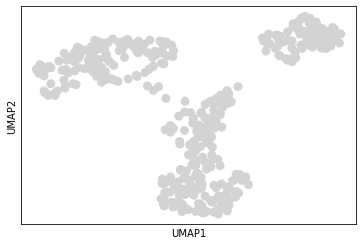

In [63]:
scanpy.pl.umap(normalized_data, use_raw=False)

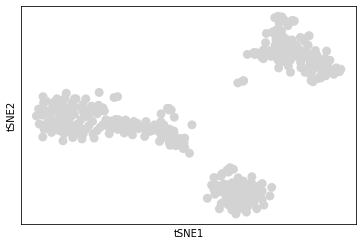

In [64]:
scanpy.tl.tsne(normalized_data)
scanpy.pl.tsne(normalized_data)

In [65]:
scanpy.tl.leiden(normalized_data)

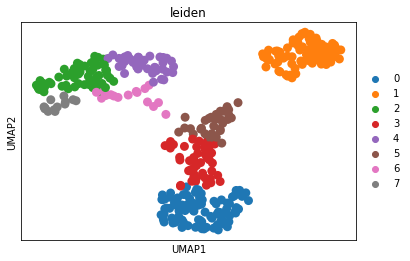

In [66]:
scanpy.pl.umap(normalized_data, color='leiden')

In [67]:
normalized_data

AnnData object with n_obs × n_vars = 375 × 4308
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

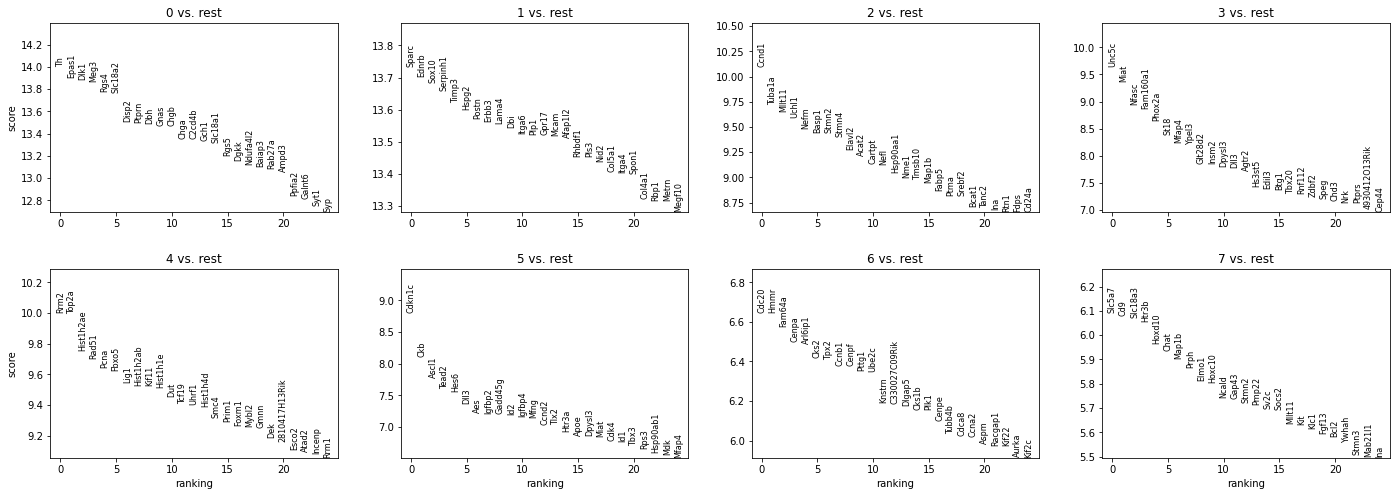

In [68]:
scanpy.tl.rank_genes_groups(normalized_data, 'leiden', method='wilcoxon', use_raw=True)
scanpy.pl.rank_genes_groups(normalized_data, n_genes=25, sharey=False)

In [69]:
normalized_data.write('/content/drive/MyDrive/Учёба РНИМУ/ranked genes')

In [70]:
pd.DataFrame(normalized_data.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,Th,Sparc,Ccnd1,Unc5c,Rrm2,Cdkn1c,Cdc20,Slc5a7
1,Epas1,Ednrb,Tuba1a,Miat,Top2a,Ckb,Hmmr,Cd9
2,Dlk1,Sox10,Mllt11,Nfasc,Hist1h2ae,Ascl1,Fam64a,Slc18a3
3,Meg3,Serpinh1,Uchl1,Fam160a1,Rad51,Tead2,Cenpa,Htr3b
4,Rgs4,Timp3,Nefm,Phox2a,Pcna,Hes6,Arl6ip1,Hoxd10


In [71]:
#found approximate cell types using https://www.genecards.org/
marker_genes_dict = {
    'Endothelial cells': ['Epas1'],
    'vascular endothelial cells': ['Ednrb'],
    'G1-S cells': ['Ccnd1', 'Top2a'],
    'Ciliated cells': ['Miat'],
    'extracellular matrix': ['Sparc'],
    'adrogenic neurons?': ['Th'],
    'Brain tissue': ['Unc5c'],
    'Lymphoid tissues': ['Rrm2'],
    'Syncytiotrophoblasts': ['Cdkn1c'],
    'Extravillous trophoblasts': ['Cdc20'],
    'Club cells': ['Slc5a7'],
    'Granulocytes': ['Slc18a2'],
    'Basophile, eosinophil': ['Cd9']
}

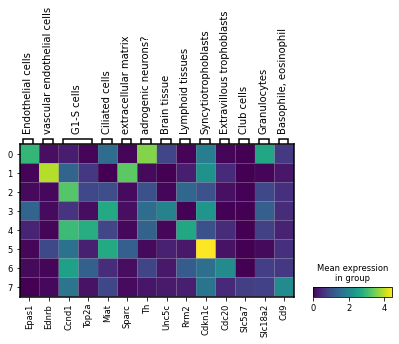

In [72]:
gs =  scanpy.pl.matrixplot(normalized_data, marker_genes_dict, groupby='leiden')